# Fine-Tune Gemma 3n for Document Understanding (Vision)

Retrieve info from invoices:

<div style="text-align: left;">
    <img src="https://private-user-images.githubusercontent.com/104844027/520976738-16c53bb8-2bf2-4989-9348-a3ffb1e3868c.png?jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3NjQ2MjAwMDMsIm5iZiI6MTc2NDYxOTcwMywicGF0aCI6Ii8xMDQ4NDQwMjcvNTIwOTc2NzM4LTE2YzUzYmI4LTJiZjItNDk4OS05MzQ4LWEzZmZiMWUzODY4Yy5wbmc_WC1BbXotQWxnb3JpdGhtPUFXUzQtSE1BQy1TSEEyNTYmWC1BbXotQ3JlZGVudGlhbD1BS0lBVkNPRFlMU0E1M1BRSzRaQSUyRjIwMjUxMjAxJTJGdXMtZWFzdC0xJTJGczMlMkZhd3M0X3JlcXVlc3QmWC1BbXotRGF0ZT0yMDI1MTIwMVQyMDA4MjNaJlgtQW16LUV4cGlyZXM9MzAwJlgtQW16LVNpZ25hdHVyZT0wNjAyYTMyMDhjZGEwZTlkYmIzNzgwMzc2YzU1ZWNkZDQ4MjdmM2YwZDk2NjVmZWVlOTU3YjQ4Y2Y4ZTc4NzE4JlgtQW16LVNpZ25lZEhlYWRlcnM9aG9zdCJ9.hM_SpdDSgoml4sEg3J5cvrKv4v0HeQOGx-7QtON50cU" style="width: 80%; display: inline-block;">
</div>

<br>

In this notebook we implement a complete multimodal fine-tuning pipeline to teach Gemma-3n to read invoices and output structured fields:
- pre-process invoice images and their ground-truth metadata
- convert each example into a multimodal chat-style input (instruction + image)
- load a 4-bit quantized Gemma-3n model using Unsloth's FastVisionModel
- apply PEFT/QLoRA to train only a small set of parameters
- fine-tune the model with the TRL SFTTrainer
- run inference using images and parse the model's natural-language output into structured JSON
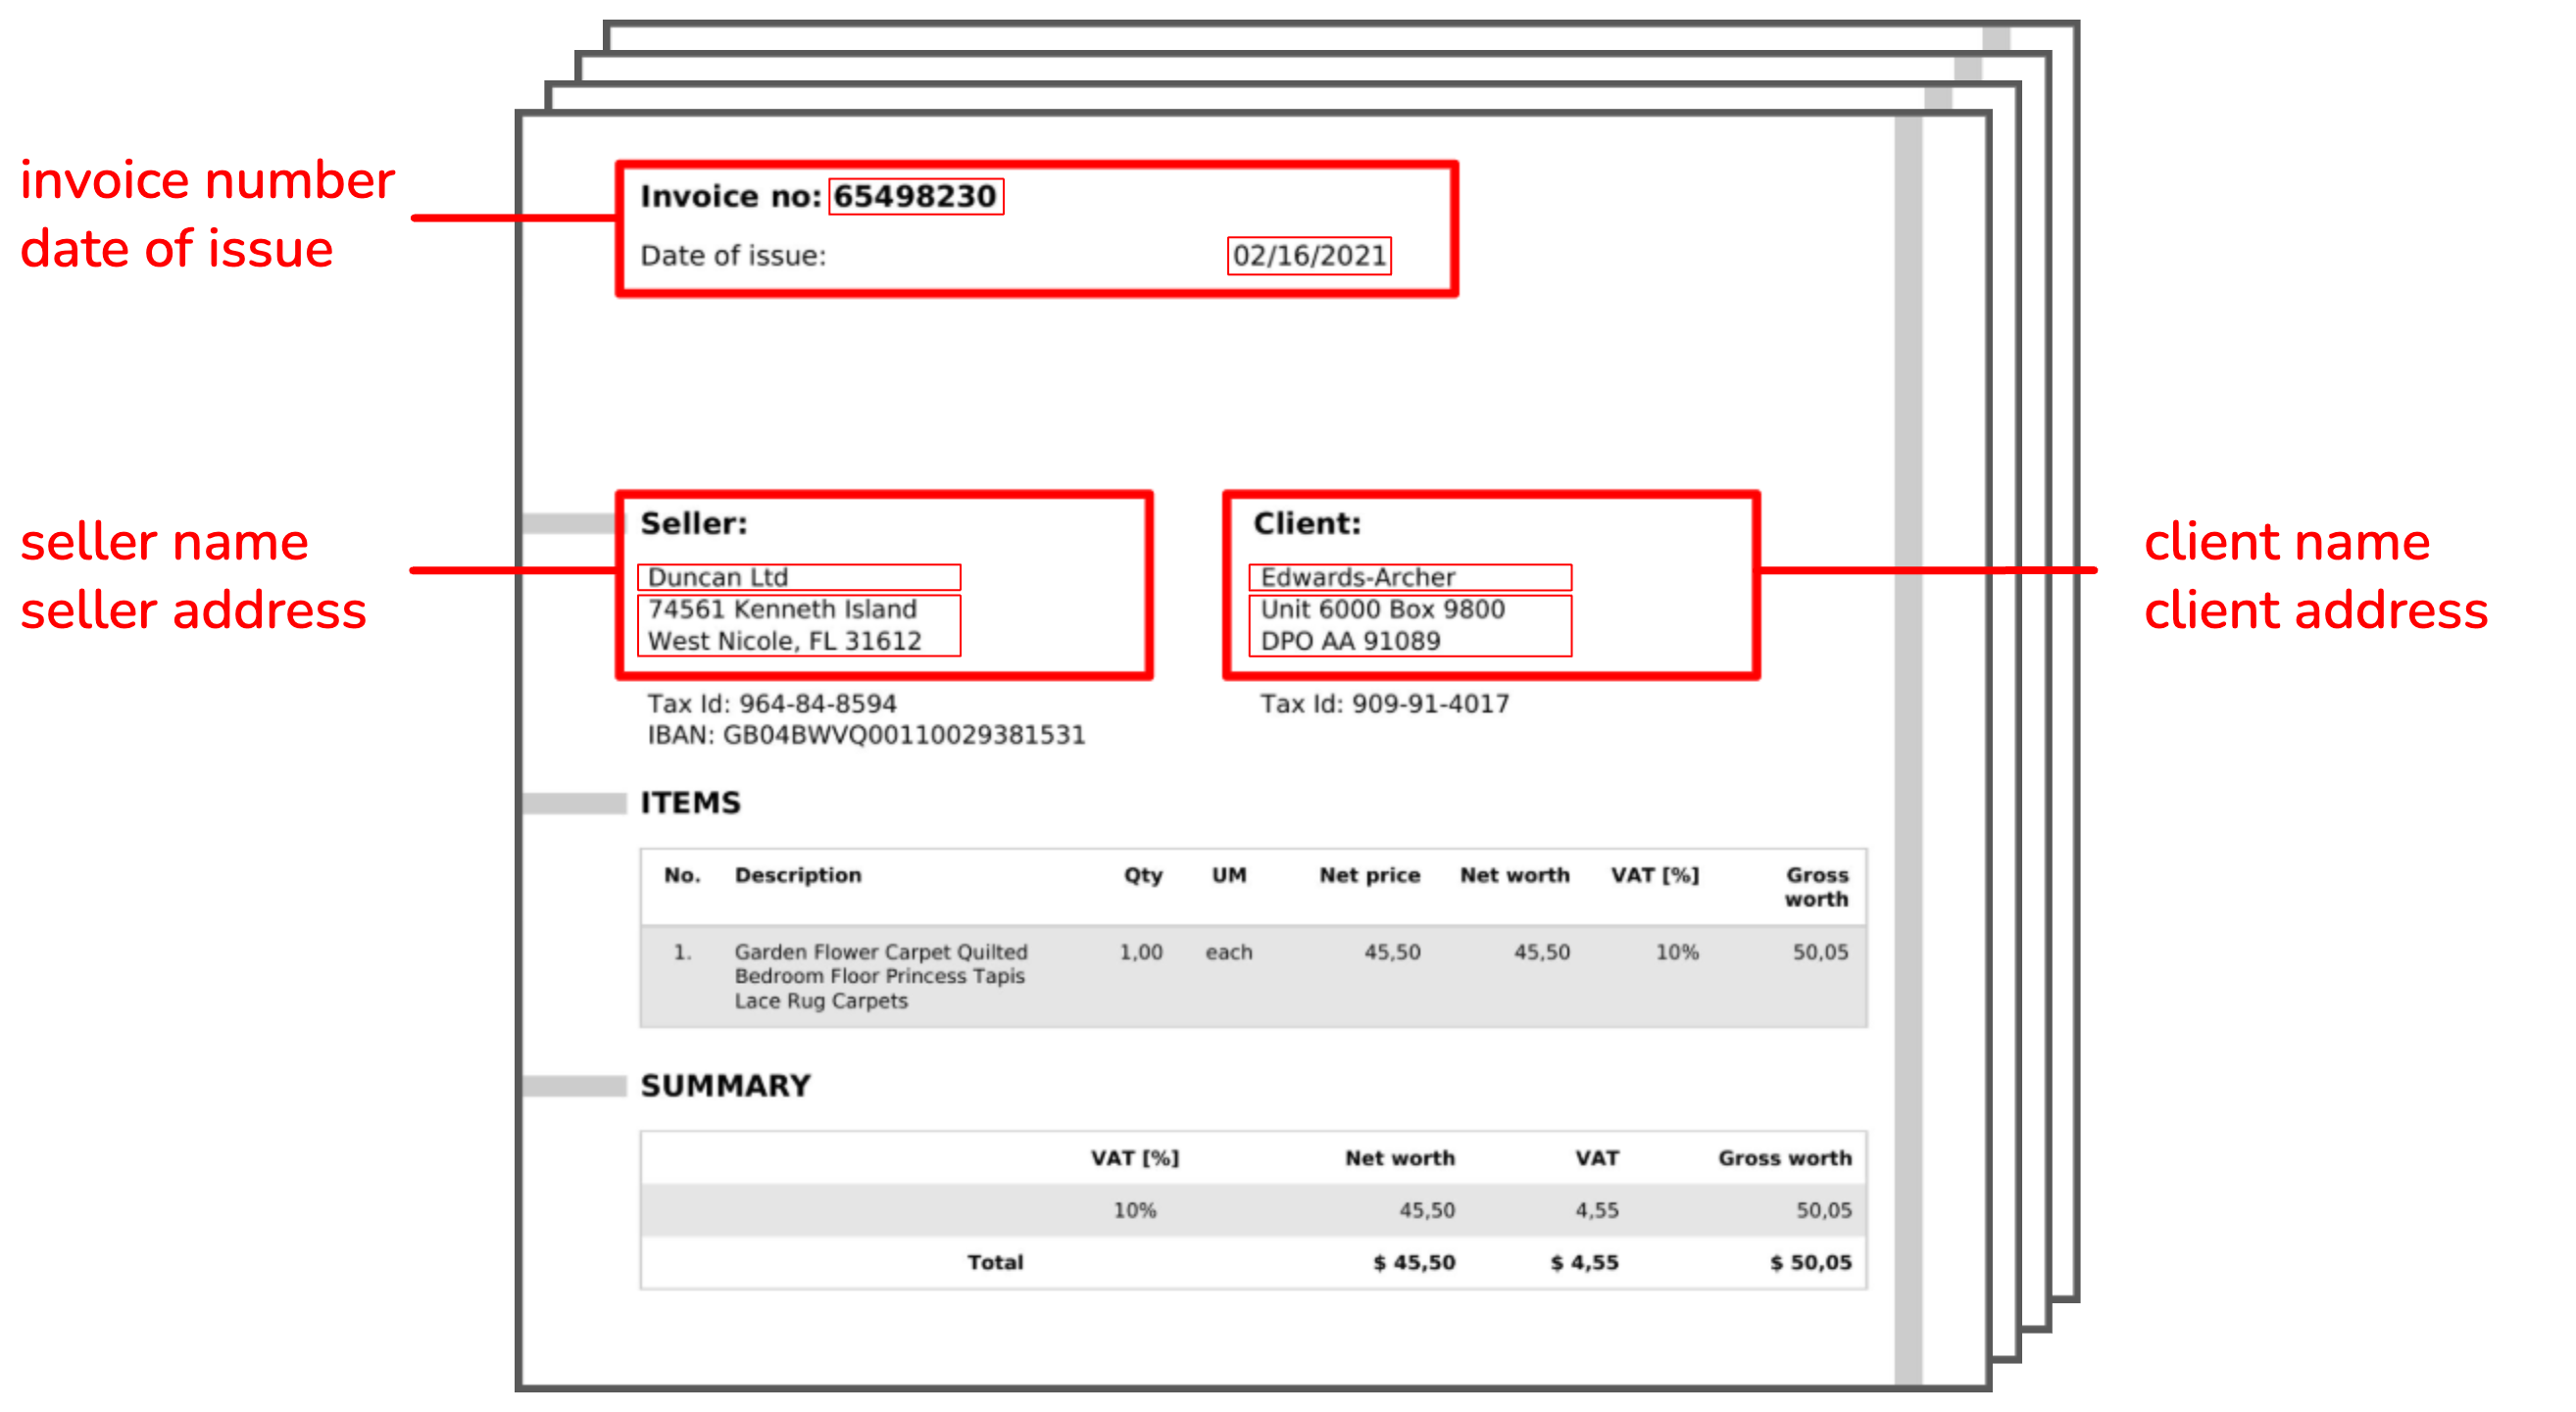

⚠️ This notebook runs in Kaggle, and has added as input the dataset [high-quality-invoice-images-for-ocr](https://www.kaggle.com/datasets/osamahosamabdellatif/high-quality-invoice-images-for-ocr).

## Dependencies

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install --no-deps --upgrade transformers
!pip install --no-deps --upgrade timm
!pip install transformers -U

## Data

In [2]:
BASE_PATH = "/kaggle/input/high-quality-invoice-images-for-ocr"

In [3]:
import csv
import json
from pathlib import Path

def load_csv(csv_path: str) -> list[dict]:
    data = []
    with Path(csv_path).open(encoding="utf-8") as f:
        for row in csv.DictReader(f):
            invoice = json.loads(row["Json Data"])["invoice"]
            for key in ("client_address", "seller_address"):
                invoice[key] = invoice[key].replace("\n", ", ")
            invoice.pop("due_date", None)
            invoice["img_name"] = row["File Name"]
            data.append(invoice)
    return data

# Load datasets
train_data = load_csv(f"{BASE_PATH}/batch_1/batch_1/batch1_1.csv")
test_data  = load_csv(f"{BASE_PATH}/batch_1/batch_1/batch1_2.csv")

In [4]:
train_data[0]

{'client_name': 'Clark-Foster',
 'client_address': '77477 Troy Cliff Apt. 853, Washingtonbury, MS 78346',
 'seller_name': 'Nguyen-Roach',
 'seller_address': '247 David Highway, Lake John, WV 84178',
 'invoice_number': '84652373',
 'invoice_date': '02/23/2021',
 'img_name': 'batch1-0494.jpg'}

In [5]:
len(train_data)

499

## Prepare data for training

In [6]:
from PIL import Image

instruction = "Extract all information from this invoice image and return it in JSON format with the following fields: client_name, client_address, seller_name, seller_address, invoice_number, and invoice_date."

def convert_data_to_conversation(sample: dict) -> dict:
    img_path = f"{BASE_PATH}/batch_1/batch_1/batch1_1/{sample['img_name']}"
    img = Image.open(img_path).convert("RGB")
    response_data = {
        "client_name":    sample["client_name"],
        "client_address": sample["client_address"],
        "seller_name":    sample["seller_name"],
        "seller_address": sample["seller_address"],
        "invoice_number": sample["invoice_number"],
        "invoice_date":   sample["invoice_date"]
    }
    response_text = json.dumps(response_data, indent=2)
    conversation = [
        {"role": "user", "content": [{"type": "text", "text": instruction}, {"type": "image", "image": img}]},
        {"role": "assistant", "content": [{"type": "text", "text": response_text}]},
    ]
    return {"messages": conversation}

converted_dataset = []
for sample in train_data:
    converted_sample = convert_data_to_conversation(sample)
    converted_dataset.append(converted_sample)

In [7]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Extract all information from this invoice image and return it in JSON format with the following fields: client_name, client_address, seller_name, seller_address, invoice_number, and invoice_date.'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1654x2339>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{\n  "client_name": "Clark-Foster",\n  "client_address": "77477 Troy Cliff Apt. 853, Washingtonbury, MS 78346",\n  "seller_name": "Nguyen-Roach",\n  "seller_address": "247 David Highway, Lake John, WV 84178",\n  "invoice_number": "84652373",\n  "invoice_date": "02/23/2021"\n}'}]}]}

In [8]:
len(converted_dataset)

499

## Model

In [9]:
from unsloth import FastVisionModel, get_chat_template
import torch

model, processor = FastVisionModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E2B-it-unsloth-bnb-4bit",
    dtype = None,
    max_seq_length = 2048,
    load_in_4bit = True,
    full_finetuning = False,
)

model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,
    r = 32,
    lora_alpha = 32,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
    target_modules = "all-linear",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-12-01 19:19:43.935789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764616784.163119      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764616784.230859      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: Could not find Trainer class in trl.trainer.bco_trainer. Found: ['BCOTrainer', '_BCOTrainer']
==((====))==  Unsloth 2025.11.6: Fast Gemma3N patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3n won't work! Using float32.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/2.65G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

Unsloth: Making `model.base_model.model.model.language_model` require gradients


## Inference (zero-shot)

In [10]:
import re

def run_inference(img):
    messages = [{"role": "user", "content": [{"type": "text", "text": instruction}, {"type": "image", "image": img}]}]
    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(img, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    eos_id = processor.tokenizer.eos_token_id
    end_turn_id = processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")
    result = model.generate(
        **inputs,
        max_new_tokens=256,
        eos_token_id=[eos_id, end_turn_id],
        pad_token_id=eos_id,
        temperature=0.7,
        top_p=0.9,
        use_cache=True
    )
    decoded = processor.batch_decode(result, skip_special_tokens=True)[0]
    assistant_answer = decoded.split("model")[-1].strip()

    # Return a JSON if possible, otherwise the raw answer
    json_match = re.search(r"\{.*?\}", assistant_answer, re.S)
    if json_match:
        return json.loads(json_match.group(0))
    return assistant_answer

In [11]:
from tqdm import tqdm
import yaml 

def get_diff_in_dict(a, b, name_a, name_b):
    diff = {}
    for k in set(a) | set(b):
        if a.get(k) != b.get(k):
            diff[k] = f"{name_a}: {a.get(k)}, {name_b}: {b.get(k)}"
    return diff

TEST_BASE_PATH = f"{BASE_PATH}/batch_1/batch_1/batch1_2"

perfect_pred = 0
wrong_pred = 0

for elem in tqdm(test_data[0:10]):
    img = Image.open(f"{TEST_BASE_PATH}/{elem['img_name']}")
    res = run_inference(img)
    if type(res) is dict:
        res['img_name'] = elem['img_name']
        if res == elem:
            print("Perfect")
            perfect_pred += 1
        else:
            print("Wrong JSON")
            diff = get_diff_in_dict(res, elem, "pred", "gt")
            print(yaml.dump(diff, sort_keys=False, allow_unicode=True))
            wrong_pred += 1
    else: 
        print(res)
        print('---')
        print(elem)
        print("Wrong type")
        wrong_pred += 1
    print(f"Perfect pred: {perfect_pred}/{perfect_pred + wrong_pred}")

 10%|█         | 1/10 [02:00<18:08, 120.95s/it]

Wrong JSON
seller_name: 'pred: Carrillo, Lara and Hooper USNV Jones, gt: Carrillo, Lara and Hooper'
client_address: 'pred: 85942 Tucker Plains Apt. 982 Hernandezchester, SC 88596, gt:
  85942 Tucker Plains Apt. 982, Hernandezchester, SC 88596'
seller_address: 'pred: PO AE 13513, gt: USNV Jones, FPO AE 13513'

Perfect pred: 0/1


 20%|██        | 2/10 [02:31<09:00, 67.62s/it] 

Wrong JSON
seller_address: 'pred: 8881 Nicholas Grove, West Endershire, WA 71685, gt: 8881 Nicholas
  Grove, West Andrewshire, WA 71685'

Perfect pred: 0/2


 60%|██████    | 6/10 [04:38<02:26, 36.52s/it]

Wrong JSON
client_address: 'pred: 6958 Ramirez Crest Mooremouth, NJ 37424, gt: 6958 Ramirez Crest,
  Mooremouth, NJ 37424'
seller_address: 'pred: 60902 Steven Trace Tylerland, MA 82522, gt: 60902 Steven Trace,
  Tylerland, MΑ 82522'

Perfect pred: 0/6


 70%|███████   | 7/10 [05:11<01:46, 35.38s/it]

Wrong JSON
client_address: 'pred: PSC 7207, Box 5750 APO AA 48779, gt: PSC 7207, Box 5750, APO
  AA 48779'
seller_address: 'pred: 5217 Morris Mountain Apt. 600 North Danfield, MI 66538, gt:
  5217 Morris Mountain Apt. 600, North Danielshire, MI 66538'

Perfect pred: 0/7


 80%|████████  | 8/10 [05:43<01:08, 34.24s/it]

Wrong JSON
client_address: 'pred: 200 Gregory Junctions Jamesmouth, NV 63642, gt: 200 Gregory
  Junctions, Jamesmouth, NV 63642'
seller_address: 'pred: 700 Jennings Shoals Apt. 008 Woodsborough, DC 14098, gt: 700
  Jennings Shoals Apt. 008, Woodsborough, DC 14098'

Perfect pred: 0/8


 90%|█████████ | 9/10 [06:16<00:33, 33.69s/it]

Wrong JSON
client_address: 'pred: 326 Gonzalez Throughway Suite 496 Lake Johnbrough, FL 59208,
  gt: 326 Gonzalez Throughway Suite 496, Lake Johnborough, FL 59208'
seller_address: 'pred: 225 Gonzales Crest Apt. 419 Holmesview, OK 39540, gt: 225 Gonzales
  Crest Apt. 419, Holmesview, OK 39540'

Perfect pred: 0/9


100%|██████████| 10/10 [06:46<00:00, 40.62s/it]

Wrong JSON
seller_address: 'pred: 595 Hoffman Prairie South James, MT 62369, gt: 595 Hoffman
  Prairie, South James, MT 62369'

Perfect pred: 0/10


## Fine-tuning

In [12]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        max_grad_norm = 0.3,
        warmup_ratio = 0.03,
        # max_steps = 100,   # alternative to num_train_epochs
        num_train_epochs = 2,
        learning_rate = 2e-4,
        logging_steps = 10,
        save_strategy="steps",
        save_steps=50,
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "invoice_ocr_outputs",
        report_to = "none",
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    )
)

gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

trainer_stats = trainer.train()

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")

Unsloth: Model does not have a default image size - using 512
Unsloth: Switching to float32 training since model cannot work with float16
GPU = Tesla T4. Max memory = 14.741 GB.
11.379 GB of memory reserved.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 499 | Num Epochs = 2 | Total steps = 250
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 42,270,720 of 5,481,708,992 (0.77% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,1.569400
20,0.062600
30,0.040200
40,0.041300
50,0.030800
60,0.026200
70,0.021200
80,0.025900
90,0.021700
100,0.020200


1566.034 seconds used for training.
26.1 minutes used for training.
Peak reserved memory = 11.379 GB.
Peak reserved memory % of max memory = 77.193 %.


## Inference (fine-tuned)

In [13]:
FastVisionModel.for_inference(model)

perfect_pred = 0
wrong_pred = 0

for elem in tqdm(test_data[0:10]):
    img = Image.open(f"{TEST_BASE_PATH}/{elem['img_name']}")
    res = run_inference(img)
    if type(res) is dict:
        res['img_name'] = elem['img_name']
        if res == elem:
            print("Perfect")
            perfect_pred += 1
        else:
            print("Wrong JSON")
            diff = get_diff_in_dict(res, elem, "pred", "gt")
            print(yaml.dump(diff, sort_keys=False, allow_unicode=True))
            wrong_pred += 1
    else: 
        print(res)
        print('---')
        print(elem)
        print("Wrong type")
        wrong_pred += 1
    print(f"Perfect pred: {perfect_pred}/{perfect_pred + wrong_pred}")

 10%|█         | 1/10 [00:33<05:03, 33.73s/it]

Perfect
Perfect pred: 1/1


 20%|██        | 2/10 [01:04<04:14, 31.77s/it]

Perfect
Perfect pred: 2/2


 30%|███       | 3/10 [01:34<03:39, 31.34s/it]

Perfect
Perfect pred: 3/3


 40%|████      | 4/10 [02:07<03:11, 32.00s/it]

Perfect
Perfect pred: 4/4


 50%|█████     | 5/10 [02:41<02:41, 32.39s/it]

Perfect
Perfect pred: 5/5


 60%|██████    | 6/10 [03:12<02:07, 31.96s/it]

Wrong JSON
seller_address: 'pred: 60902 Steven Trace, Tylerland, MA 82522, gt: 60902 Steven Trace,
  Tylerland, MΑ 82522'

Perfect pred: 5/6


 70%|███████   | 7/10 [03:46<01:37, 32.59s/it]

Wrong JSON
seller_address: 'pred: 5217 Morris Mountain Apt. 600, North Danielleshire, MI 66538,
  gt: 5217 Morris Mountain Apt. 600, North Danielshire, MI 66538'

Perfect pred: 5/7


 80%|████████  | 8/10 [04:18<01:05, 32.56s/it]

Perfect
Perfect pred: 6/8


 90%|█████████ | 9/10 [04:52<00:32, 32.84s/it]

Perfect
Perfect pred: 7/9


100%|██████████| 10/10 [05:22<00:00, 32.27s/it]

Perfect
Perfect pred: 8/10
